# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [199]:
import os

import pickle
import time

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model, dummy
from sklearn import svm

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [200]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [201]:
def print_listdir( path=None, level=0, exclude=[] ) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 devel
 |- Exploration_v0 (copy).ipynb
 |- Exploration_v0.ipynb
 |- Modelisation_energy_v0.ipynb
 |- regressor.ipynb
 install_packages_venv.sh


Chargement / compression des données

In [202]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype = pd.read_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location = pd.read_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)
df_annexe = pd.read_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)

print('df:', df.shape)
print('df_hotencoding_usetype:', df_hotencoding_usetype.shape)
print('df_hotencoding_location:', df_hotencoding_location.shape)
print('df_annexe:', df_annexe.shape)
print('df columns:', df.columns.tolist())

df: (1649, 12)
df_hotencoding_usetype: (1649, 21)
df_hotencoding_location: (1649, 13)
df_annexe: (1649, 7)
df columns: ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', '%GFAParking', '%GFABuilding(s)', 'SiteEUIWN(kBtu/sf)', '% SteamUse', '% Electricity', '% NaturalGas', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)']


In [203]:
df.drop( columns='GHGEmissionsIntensity', inplace=True )

df = pd.concat( (df, df_hotencoding_location, df_hotencoding_usetype), axis=1 )
print('df shape:', df.shape)

sr_loc = df.isna().sum(1) == 0

df = df.loc[ sr_loc, :]

target = 'SiteEUIWN(kBtu/sf)'
y = df[target]
df.drop( columns=target, inplace=True )

print('df shape:', df.shape)
print('y shape:', y.shape)


df.head()

df shape: (1649, 45)
df shape: (1648, 44)
y shape: (1648,)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFAParking,%GFABuilding(s),% SteamUse,% Electricity,% NaturalGas,Outlier,AgeOfBuilding(s),ballard,central,delridge,downtown,east,greater duwamish,lake union,magnolia / queen anne,north,northeast,northwest,southeast,southwest,data center,distribution center,education,entertainment/public assembly,lifestyle center,manufacturing/industrial plant,medical,medical office,non-refrigerated warehouse,office,other,other - entertainment/public assembly,refrigerated warehouse,residential - hotel,restaurant,science,self-storage facility,services,store,utility,worship facility
0,1.0,12,88434,0.000000,1.000000,0.277302,0.546060,0.176638,0,89,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,11,103566,0.145453,0.854547,0.000000,0.386609,0.613391,0,20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809918,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,41,956110,0.205748,0.794252,0.297113,0.682307,0.020579,0,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,10,61320,0.000000,1.000000,0.325913,0.407519,0.266567,0,90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,18,175580,0.353115,0.646885,0.000000,0.378802,0.621198,0,36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644776,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


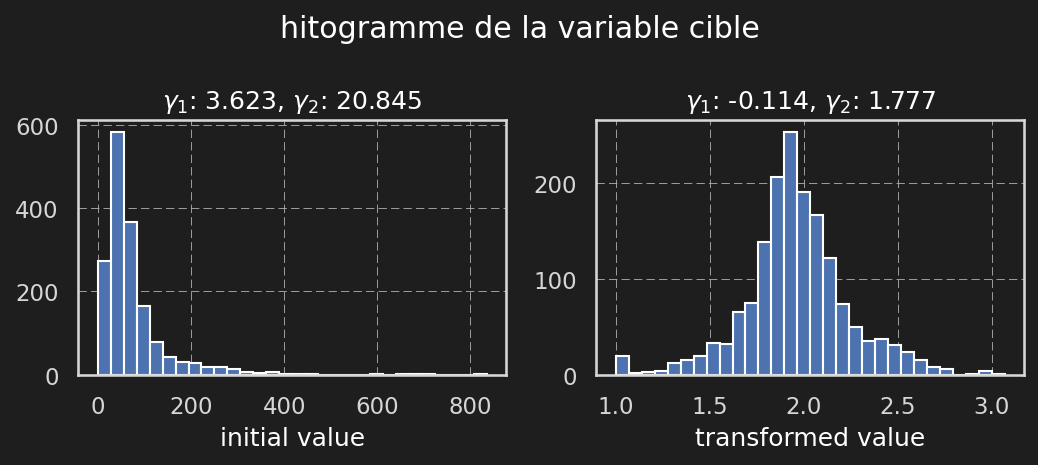

In [204]:
class TargetTransformer:
    def __init__(self, y):
        self.cst = 1.-y.min()
    def transform(self, y ):
        return (y+self.cst)**(1/6)
    def reverse(self, y_transformed ):
        return self.cst + y_transformed**6

transformers = {'y': TargetTransformer(y)}
y_transformed = transformers['y'].transform(y)

fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
axs[0].hist( y, bins=30 )
axs[1].hist( y_transformed, bins=30 )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_transformed), st.kurtosis(y_transformed) ) )

axs[0].set_xlabel('initial value')
axs[1].set_xlabel('transformed value')

fig.suptitle('hitogramme de la variable cible')
fig.tight_layout()

***
# Definitions

In [205]:
def train_model( model_name, model, param_grid, score='r2' ): 
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    modelCV = model_selection.GridSearchCV(
        model, # modèle
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=score,   # score à optimiser
        n_jobs=-1
    )

    t0 = time.time()
    modelCV.fit(X_train, y_train)
    model_to_results( model_name, modelCV, X_test, time.time()-t0 )

    return modelCV

def log_transfrom( x ):
    return np.log( x + ( 1. - min([0, x.min()]) ) )

def print_coefs( coefs, features ):
    n_features_0 = len( features )

    print('coefficients linear:')
    print(coefs[:n_features_0])

    if len( coefs ) > n_features_0:
        print('coefficients non-linear:')
        print(coefs[n_features_0:])

    print('linear coefs == 0 for :') #, np.array(features)[ coefs[:n_features_0+1] == 0. ])
    print('[', end='')
    for feature in np.array(features)[ coefs[:n_features_0] == 0. ]:
        print( f"'{feature}', ", end='')
    print(']')

    if len( coefs ) > n_features_0+1:
        print('non-linear coefs == 0 for :', np.array(features[1:])[ coefs[n_features_0+1:] == 0. ])

def histogram_per_coef( X, coefs, features ):
    y = (X @ coefs.reshape(-1,1)).ravel()
    for xi, coef, feature in zip( X.transpose(), coefs, features):
        fig, ax = plt.subplots( figsize=(12*cm,8*cm))
        ax.hist( xi*(coef*100)/y, bins=50 )
        ax.set_ylabel('count')
        ax.set_xlabel('influence sur la cible (%)')
        ax.set_title(feature)

In [206]:
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       '%GFAParking', '%GFABuilding(s)', '% SteamUse', '% Electricity',
       '% NaturalGas', 'Outlier', 'AgeOfBuilding(s)', 'ballard', 'central',
       'delridge', 'downtown', 'east', 'greater duwamish', 'lake union',
       'magnolia / queen anne', 'north', 'northeast', 'northwest', 'southeast',
       'southwest', 'data center', 'distribution center', 'education',
       'entertainment/public assembly', 'lifestyle center',
       'manufacturing/industrial plant', 'medical', 'medical office',
       'non-refrigerated warehouse', 'office', 'other',
       'other - entertainment/public assembly', 'refrigerated warehouse',
       'residential - hotel', 'restaurant', 'science', 'self-storage facility',
       'services', 'store', 'utility', 'worship facility'],
      dtype='object')

In [207]:
df.columns.get_loc( 'PropertyGFATotal')

2

In [208]:
X = df.values
features_X = df.columns.tolist()

i = df.columns.get_loc( 'PropertyGFATotal')
X[:,i] = np.log( X[:,i] )

# X = X + 1. - X.min(0).reshape(1, -1)


X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0)
y_train, y_test = y_train.values, y_test.values
scaler = preprocessing.StandardScaler().fit( X_test )
# scaler = preprocessing.PowerTransformer(method='box-cox' ).fit( X_test )
X_test = scaler.transform( X_test )
X_train = scaler.transform( X_train )

In [209]:
print('X', X.shape)
print( 'X_train:', X_train.shape )

X (1648, 44)
X_train: (1236, 44)


In [210]:
dico_results = {'y_test':y_test}

In [211]:
def plot_results( label ):
    y_test, y_pred = dico_results['y_test'], dico_results[label]['y_pred']

    argsort = y_test.argsort()
    fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    ax.plot( y_test[argsort], 'r', label='data' )
    ax.plot( y_pred[argsort], 'bo', markersize=2, label=label )
    ax.legend()
    ax.set_xlabel('sample')

    fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    ax.plot( y_test, y_pred, 'bo', markersize=2, label=f'prediction {label}' )
    xy_optim = [y_test.min(), y_test.max()]
    ax.plot( xy_optim, xy_optim, 'r', label='optimal fit' )
    ax.legend()
    ax.set_xlabel( 'prediction ' + label)
    imin = y_test.argmin()
    print( y_pred[imin], y_test[imin] )

    ax.set_ylabel( 'y transformed' )

def model_to_results( name, model, X_test, training_time ):
    dico_results[name] = {'y_pred': model.predict(X_test),
                        'training time': training_time,
                        'model':model }

def print_results( ):
    y_test = dico_results['y_test']
    df_results = pd.DataFrame( index=['training time (sec.)', 'MSE', 'R2 score'])
    for (name, results) in dico_results.items():
        if name == 'y_test' :
            continue
        y_pred = results['y_pred']
        df_results[name] = [results['training time'], 
                            metrics.mean_squared_error(y_test, y_pred),
                            metrics.r2_score(y_test, y_pred) ]
    
    display( df_results )

# Dummy Regressor

In [212]:
model_name = 'dummy median'
t0 = time.time()
dr = dummy.DummyRegressor( strategy='median' ).fit( X_train, y_train )
model_to_results( model_name, dr, X_test, time.time()-t0 )

In [213]:
dico_results.keys()

dict_keys(['y_test', 'dummy median'])

,dummy median
training time (sec.),0.000885
MSE,8039.362933
R2 score,-0.085691


53.75 0.0


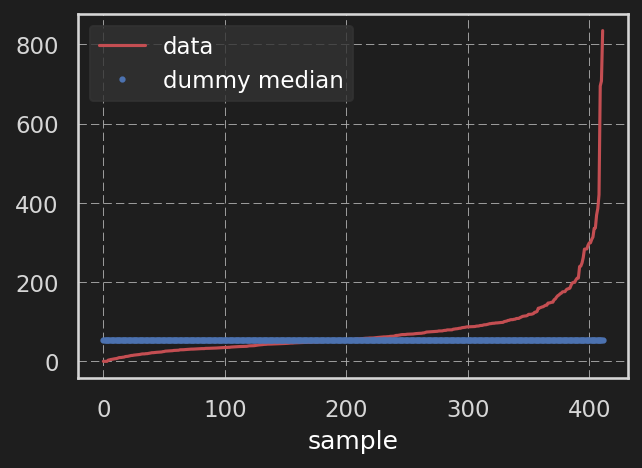

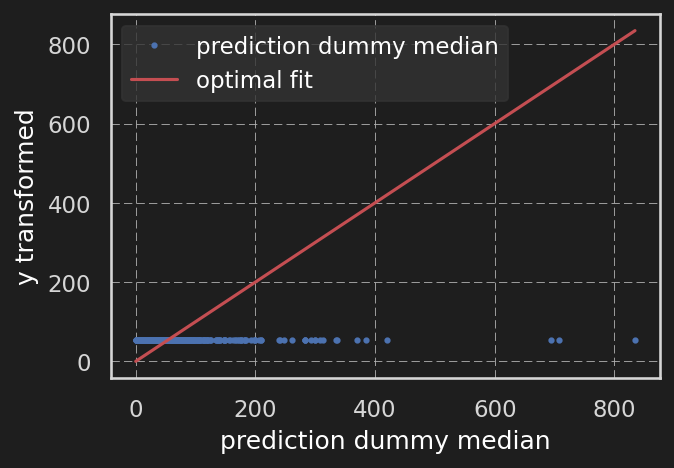

In [214]:
print_results()
plot_results( model_name )

***
# Lasso

In [215]:
model_name = 'lasso'
alphas_lasso = np.logspace(-5, 0, 100)
t0 = time.time()
model = linear_model.LassoCV( alphas=alphas_lasso, cv=5 ).fit( X_train, y_train )

model_to_results( model_name, model, X_test, time.time()-t0 )
_, coefs_lasso, _ = linear_model.lasso_path( X_train, y_train, alphas=alphas_lasso )

Objective did not converge. You might want to increase the number of iterations. Duality gap: 131286.6121216677, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 366726.5282587176, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 582788.1965577314, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 754953.4339448214, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 892131.1821766226, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 985589.5059064366, tolerance: 1295.487633637749
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044161.111425457, tolerance: 1295.487633637749
Object

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
alpha: 0.0774263682681127


,dummy median,lasso
training time (sec.),0.000885,0.201892
MSE,8039.362933,3183.353024
R2 score,-0.085691,0.570098


31.1200655655729 0.0
coefficients linear:
[ 1.52978326e+01  4.94573127e-01 -1.95367465e+00  4.16951546e+00
 -3.19635719e-16  8.09229634e-01 -1.52349829e+01  0.00000000e+00
  5.33445502e+00 -8.71453370e+00 -1.74216024e+00 -9.66118033e-01
  1.37407519e+00 -8.61258704e-01  2.36933504e-01  0.00000000e+00
 -1.42001563e+00  1.69956014e+00 -2.78576220e+00  2.10567199e+00
  1.38864776e-01 -1.27833092e+00  3.45934838e+00  5.43526177e+01
 -7.43744522e+00 -1.18857403e+01  7.98398282e+00  7.80144177e-01
  1.49992125e+00  8.75262925e+00  1.54318242e+00 -1.25689308e+01
 -3.51799387e+00  3.11823664e+00 -5.33527410e-01  1.14237581e+00
 -3.41207532e+00  1.16676749e+01  1.41758257e+01 -7.04360469e+00
 -6.31176106e-01  1.21211930e+01 -1.60651140e+00 -1.13207940e+01]
linear coefs == 0 for :
['% NaturalGas', 'greater duwamish', ]

sorted coefs:
% NaturalGas: 0.000000
greater duwamish: 0.000000
%GFABuilding(s): -0.000000
northwest: 0.138865
east: 0.236934
NumberofFloors: 0.494573
other - entertainment/publi

Text(0.5, 1.0, 'train set')

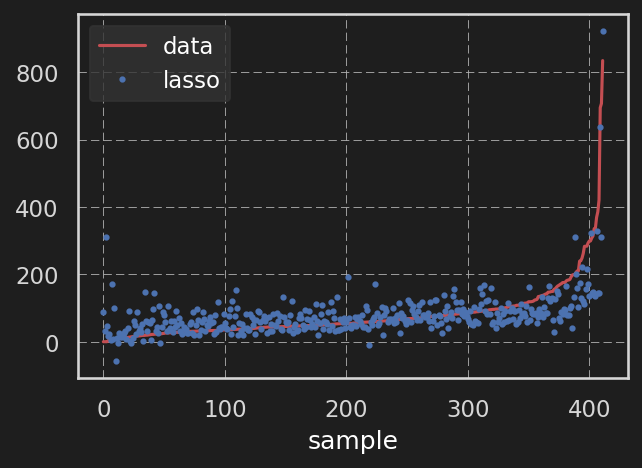

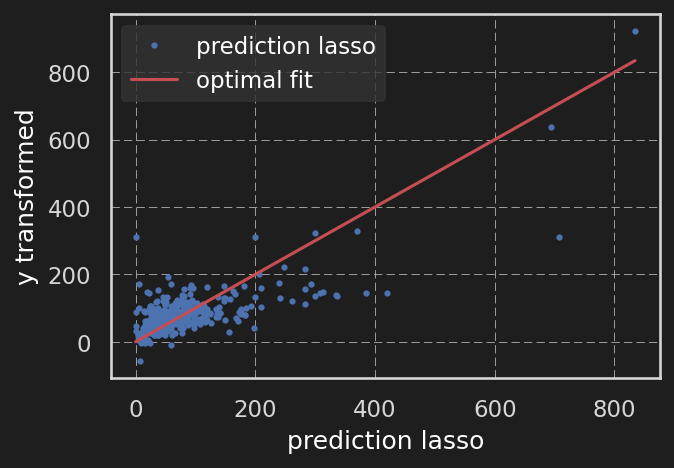

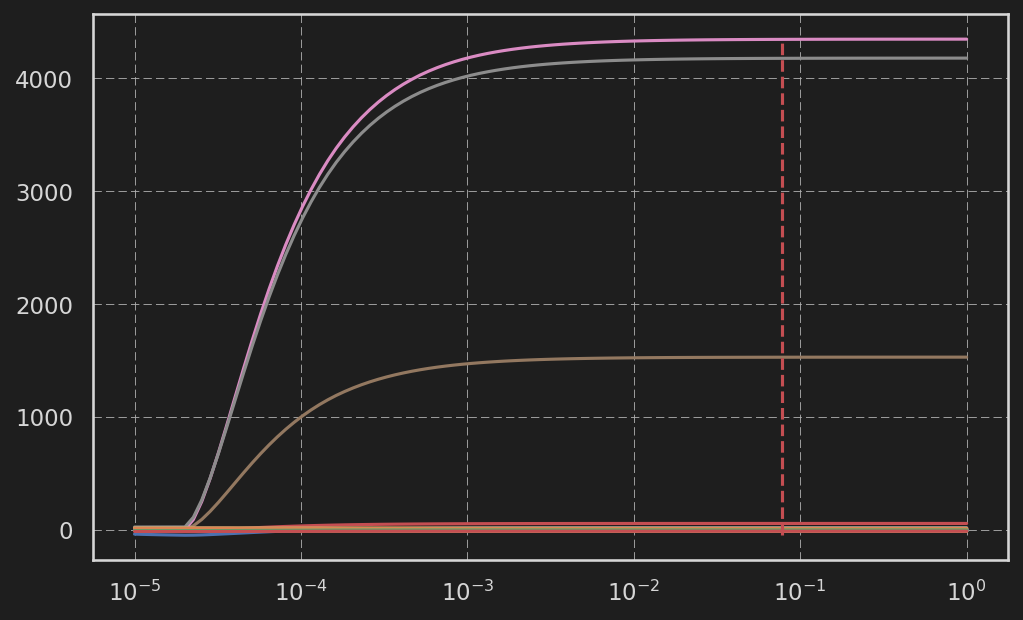

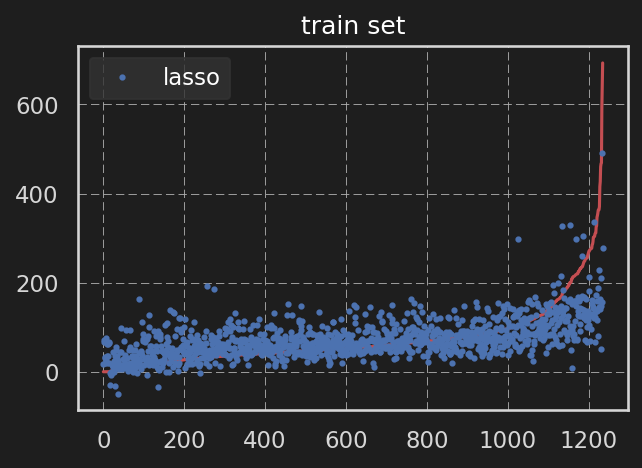

In [216]:
alpha_lassoCV = model.alpha_
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print( 'alpha:', alpha_lassoCV)

print_results()
plot_results( model_name )

# print( alphas_lasso.shape )
# print(coefs_lasso.shape)
# print(X_train.shape)

# histogram_per_coef( X_train, model.cohistogram_per_coef( X, coefs, features )ef_, features_X )

print_coefs( model.coef_, features_X )
argsort = np.abs(model.coef_).argsort()
print('\nsorted coefs:')
for i in argsort:
    print( f'{features_X[i]}: { model.coef_[i]:.6f}' )

print('\nlowest coefs:')
print('[', end='')
for i in argsort[:-10]:
    print( f"'{features_X[i]}', ", end='')
print(']')

fig, ax = plt.subplots( figsize=(20*cm,12*cm) )
for feature, coefs in zip( features_X, coefs_lasso ):
    ax.semilogx( alphas_lasso, coefs, label=feature)
# ax.semilogx( alphas_lasso, coefs_lasso.transpose() )
ax.plot( [alpha_lassoCV,]*2, [coefs_lasso.min(), coefs_lasso.max()], 'r--' )
# ax.legend()



argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()
ax.set_title('train set')

***
# Elastic net

In [217]:
# help( linear_model.ElasticNet )

In [218]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

In [219]:
model_name = 'Elastic net'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'l1_ratio':np.geomspace(0.5, 0.99, 10),
            'alpha':np.logspace(-5, 1, 20)}

model = train_model( model_name, linear_model.ElasticNet(random_state=0), param_grid )

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+06, tolerance: 5.039e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+06, tolerance: 4.873e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

In [220]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

print_coefs( model.best_estimator_.coef_, features_X )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.06158482110660261, 'l1_ratio': 0.7307755339398913}
coefficients linear:
[ 11.48611423   0.62836515  -1.60660638   2.07311509  -2.03916089
   3.10418293  -8.20927506   6.43269591   5.35507698  -8.51341467
  -1.60304405  -0.89703096   1.47684154  -0.77909395   0.31405713
   0.          -1.21315409   1.83704364  -2.70165618   2.17541045
   0.28309536  -1.29425046   3.45876303  45.84107739  -7.13755831
 -11.3531812    8.07189532   0.88416646   1.60038096   8.8666358
   1.68227569 -12.08665087  -3.06731618   3.43528234  -0.45791893
   1.25119846  -3.13216038  11.57833944  14.09253951  -6.81670958
  -0.56900642  12.25045285  -1.46457876 -10.85532846]
linear coefs == 0 for :
['greater duwamish', ]


,dummy median,lasso,Elastic net
training time (sec.),0.000885,0.201892,4.127940
MSE,8039.362933,3183.353024,3140.812009
R2 score,-0.085691,0.570098,0.575843


32.24676534850179 0.0
train MSE: 3087.379
train r2: 0.391


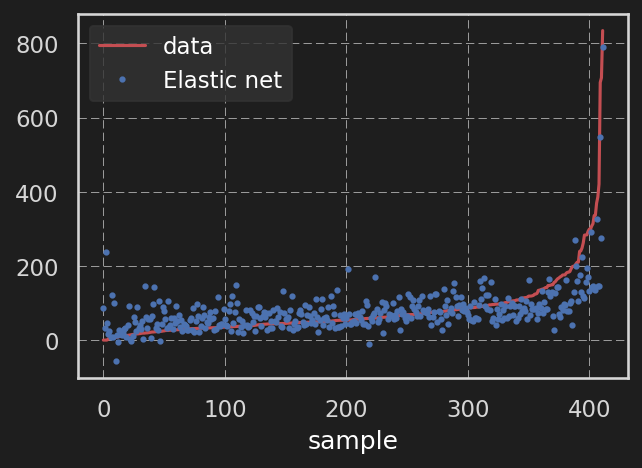

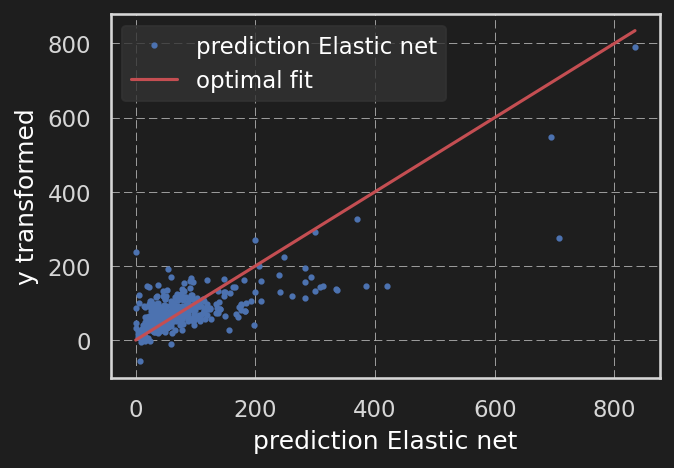

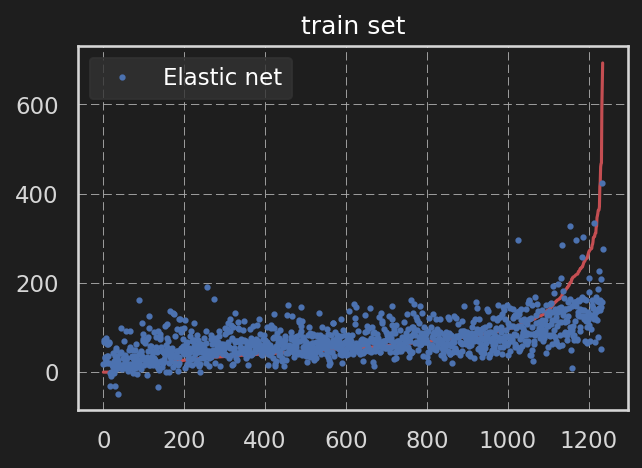

In [221]:
print_results()
plot_results( model_name )

print( 'train MSE: {:.3f}'.format( metrics.mean_squared_error( y_train, model.predict(X_train) ) ) )
print( 'train r2: {:.3f}'.format( metrics.r2_score( y_train, model.predict(X_train) ) ) )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()
ax.set_title('train set')

if False:
    fig, ax = plt.subplots( figsize=(12*cm,8*cm))
    ax.plot( [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r' )
    ax.plot( y_train, model.predict( X_train) , 'bo', markersize=3 )

***
# SVR

In [222]:
from sklearn.svm import LinearSVR
# help( LinearSVR )

model_name = 'Linear SVR'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
            'C':np.logspace(-5, 10, 20)
            }


model = train_model( model_name, LinearSVR( dual=False ), param_grid)


100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/svm/_classes.py", line 518, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/thomas/Documents/Formations/OpenClassRoom

,dummy median,lasso,Elastic net,Linear SVR
training time (sec.),0.000885,0.201892,4.127940,0.264707
MSE,8039.362933,3183.353024,3140.812009,3148.314275
R2 score,-0.085691,0.570098,0.575843,0.574830


30.905060427402674 0.0


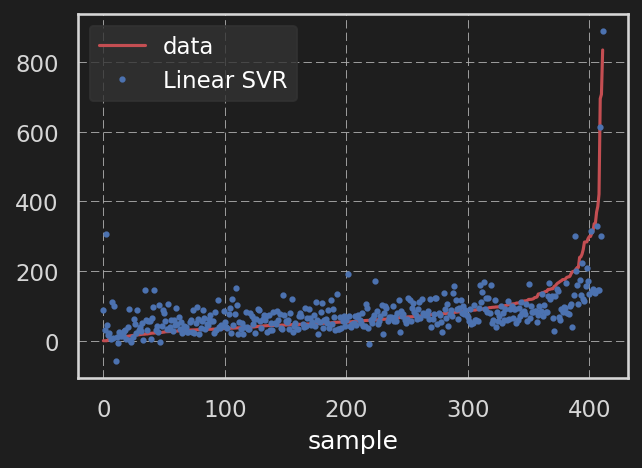

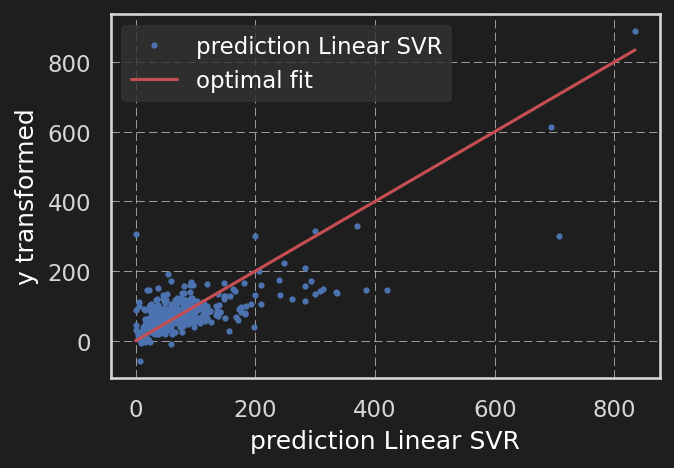

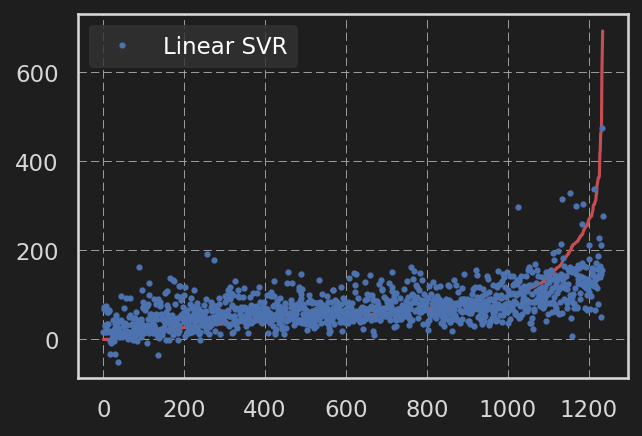

In [223]:
print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Kernel Ridge

In [224]:
from sklearn import kernel_ridge

model_name = 'Kernel ridge'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'alpha':np.logspace(-4, -2, 10),
            'gamma':np.logspace(-4, -2, 10),
            }

model = train_model( model_name, kernel_ridge.KernelRidge(kernel='rbf'), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'gamma': 0.000774263682681127}


,dummy median,lasso,Elastic net,Linear SVR,Kernel ridge
training time (sec.),0.000885,0.201892,4.127940,0.264707,14.856876
MSE,8039.362933,3183.353024,3140.812009,3148.314275,3076.537153
R2 score,-0.085691,0.570098,0.575843,0.574830,0.584523


24.06721353714238 0.0


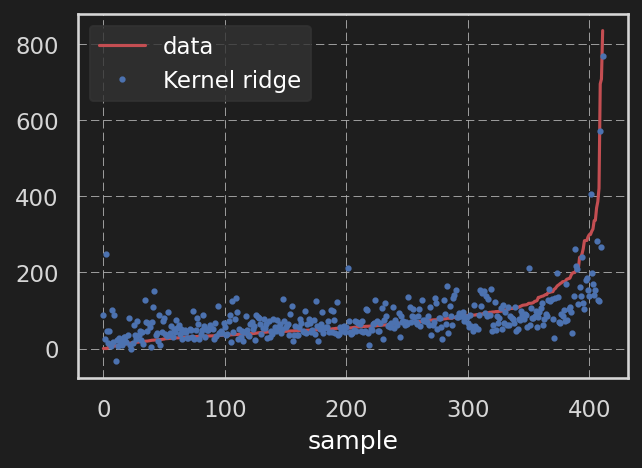

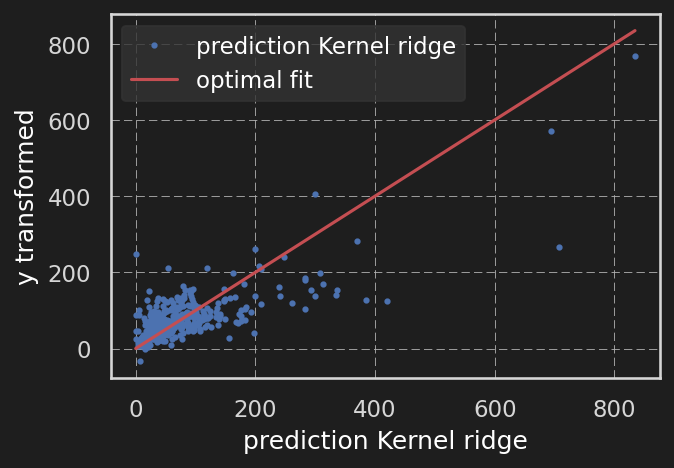

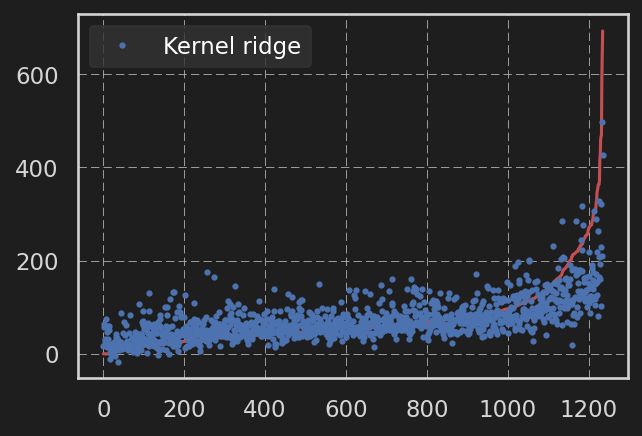

In [225]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Kernel SVR

In [226]:
help( svm.SVR )

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer or
 |  other :ref:`kernel_approximation`.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomput

In [227]:
model_name = 'Kernel SVR'

# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'C':np.logspace(0, 4, 10),
            'gamma':np.logspace(-5, -3, 10),
            }

model = train_model( model_name, svm.SVR(kernel='rbf'), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 3593.813663804626, 'gamma': 0.001}


,dummy median,lasso,Elastic net,Linear SVR,Kernel ridge,Kernel SVR
training time (sec.),0.000885,0.201892,4.127940,0.264707,14.856876,8.254193
MSE,8039.362933,3183.353024,3140.812009,3148.314275,3076.537153,4211.308734
R2 score,-0.085691,0.570098,0.575843,0.574830,0.584523,0.431276


35.88221476778671 0.0


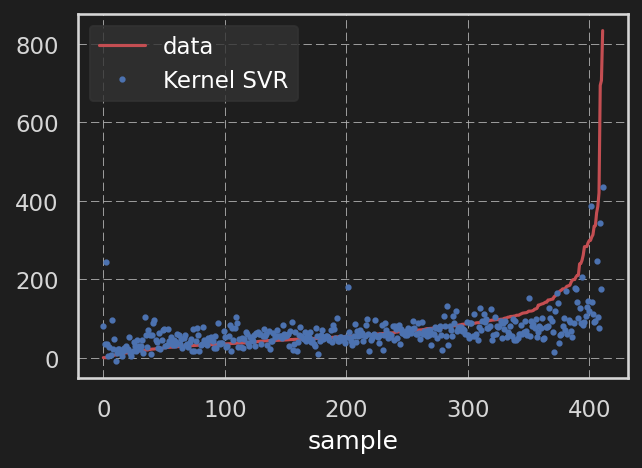

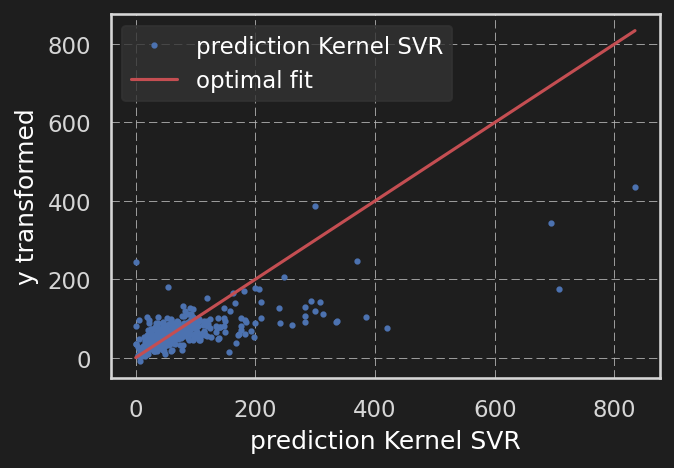

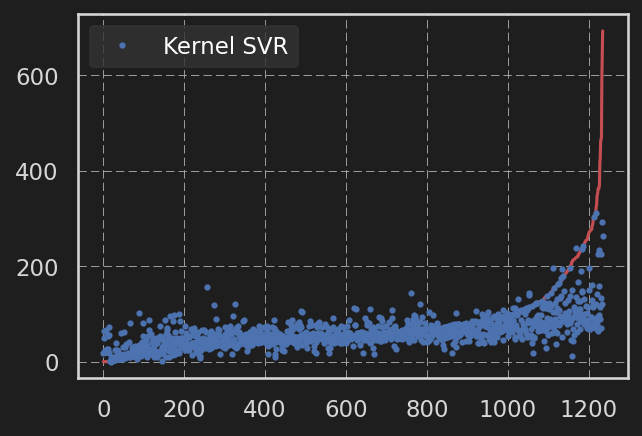

In [228]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()

***
# Random Forest

In [230]:
from sklearn.ensemble import RandomForestRegressor
# help( RandomForestRegressor )

model_name = 'Random forest'
param_grid = {
    'n_estimators':[300, 400, 500],
    'min_samples_split': [10, 20, 50],
    'max_depth':[None, 5, 10]
}

model = train_model( model_name, RandomForestRegressor(), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'min_samples_split': 20, 'n_estimators': 500}


,dummy median,lasso,Elastic net,Linear SVR,Kernel ridge,Kernel SVR,Random forest
training time (sec.),0.000885,0.201892,4.127940,0.264707,14.856876,8.254193,60.827245
MSE,8039.362933,3183.353024,3140.812009,3148.314275,3076.537153,4211.308734,3661.361218
R2 score,-0.085691,0.570098,0.575843,0.574830,0.584523,0.431276,0.505545


40.856238378812016 0.0


Text(0.5, 1.0, 'train set')

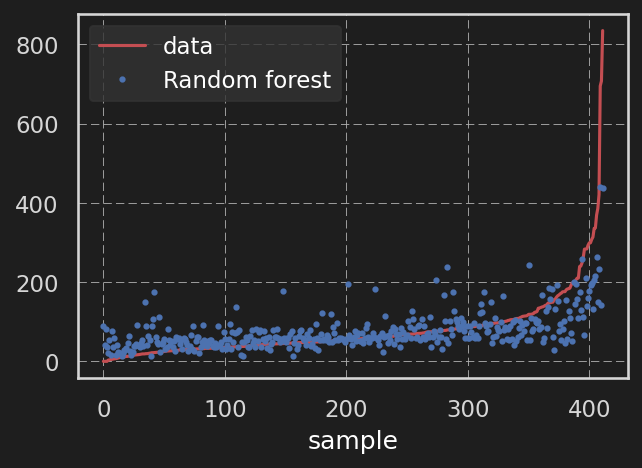

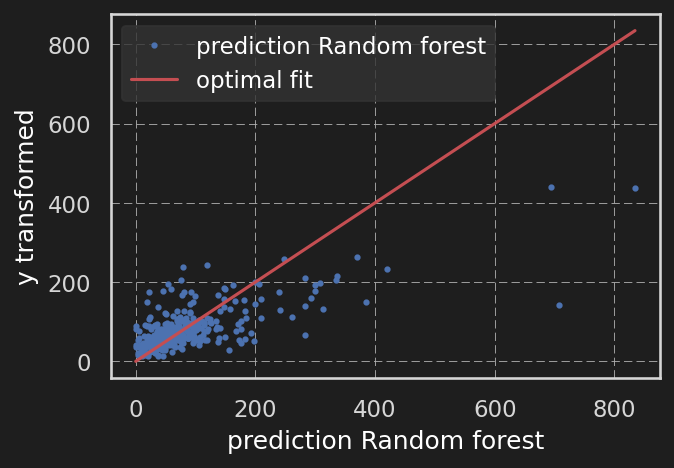

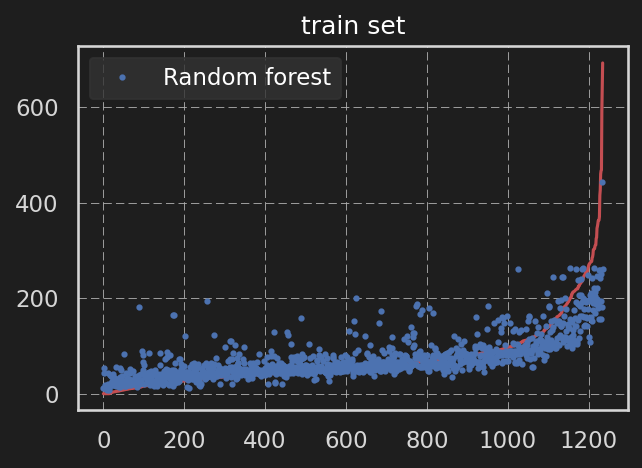

In [231]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()
ax.set_title('train set')

***
# LightGBM

In [232]:
import lightgbm as lgb

model_name = 'Light GBM'
param_grid = {
    'n_estimators': [150, 200, 300],
    # 'max_features': [ i  for i in range(1, X.shape[1], 10) ] + [X.shape[1]],
    'subsample': np.arange(0.1, 1.1, 0.1),
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
    'max_depth': np.arange(2, 11, 2),
}

model = train_model( model_name, lgb.LGBMRegressor(), param_grid )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.1}


,dummy median,lasso,Elastic net,Linear SVR,Kernel ridge,Kernel SVR,Random forest,Light GBM
training time (sec.),0.000885,0.201892,4.127940,0.264707,14.856876,8.254193,60.827245,43.997630
MSE,8039.362933,3183.353024,3140.812009,3148.314275,3076.537153,4211.308734,3661.361218,5875.322144
R2 score,-0.085691,0.570098,0.575843,0.574830,0.584523,0.431276,0.505545,0.206556


45.8695840474905 0.0


Text(0.5, 1.0, 'train set')

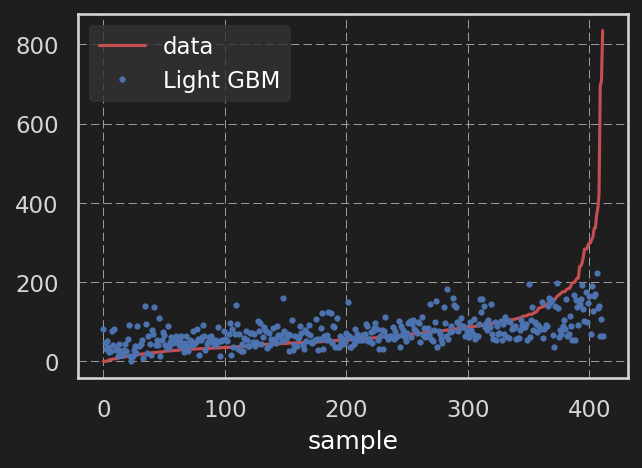

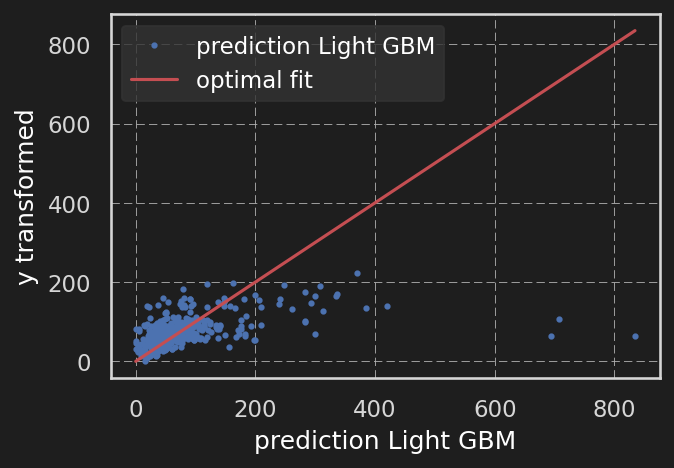

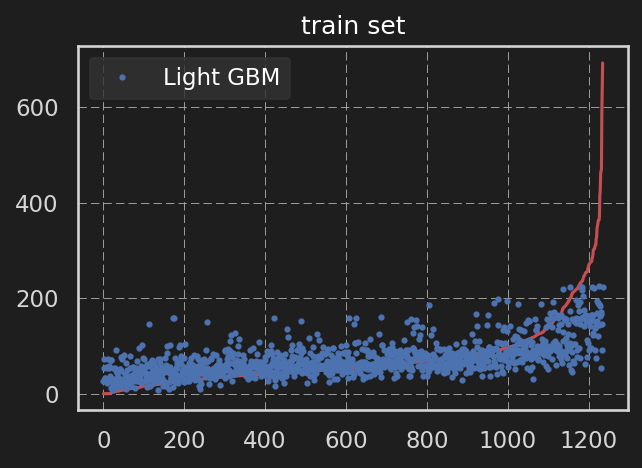

In [233]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)


print_results()
plot_results( model_name )

argsort = y_train.argsort()
fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
ax.plot( y_train[argsort], 'r' )
ax.plot( model.predict( X_train )[argsort], 'bo', markersize=2, label=model_name )
ax.legend()
ax.set_title('train set')